# Trabajo practico 1: TinyGPT

### Alumno: Maxim Dorogov

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Downloading Dataset

In [2]:
# read file from disk
with open("dataset/input.txt", "r") as f:
    text = f.read()

text = text[:100_00]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [3]:
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [27]:
chars = sorted(list(set(text)))

vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]


print(train_data)

tensor([15, 39, 48,  ..., 50, 38, 45])


# Dataloaders

In [28]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [29]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 57, 'bias': True, 'ff_class': None, 'moe': None}


In [30]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

In [31]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [33]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [34]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [35]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [36]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)
print(f"Using device: {device}")

Using device: cuda


In [37]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 100

# Training

In [38]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/1121 [00:00<?, ?it/s]W1124 01:15:34.110038 87450 site-packages/torch/_inductor/utils.py:1436] [1/0] Not enough SMs to use max_autotune_gemm mode
W1124 01:15:34.110038 87450 site-packages/torch/_inductor/utils.py:1436] [1/0] Not enough SMs to use max_autotune_gemm mode
loss 2.12475: 100%|██████████| 1121/1121 [00:18<00:00, 61.81it/s] 


Epoch 1 training loss: 2.1002


  0%|          | 0/121 [00:00<?, ?it/s]/home/maxim/anaconda3/envs/SV_analytics/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/home/maxim/anaconda3/envs/SV_analytics/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
val_loss 2.51419: 100%|██████████| 121/121 [00:03<00:00, 32.87it/s]


Epoch 1 validation loss: 2.2706


loss 2.02926: 100%|██████████| 1121/1121 [00:08<00:00, 132.94it/s]


Epoch 2 training loss: 2.0377


val_loss 2.49959: 100%|██████████| 121/121 [00:00<00:00, 264.53it/s]


Epoch 2 validation loss: 2.2011


loss 1.87786: 100%|██████████| 1121/1121 [00:08<00:00, 139.95it/s]



Epoch 3 training loss: 1.9167


val_loss 2.50207: 100%|██████████| 121/121 [00:00<00:00, 255.43it/s]


Epoch 3 validation loss: 2.1879


loss 1.87036: 100%|██████████| 1121/1121 [00:07<00:00, 141.25it/s]



Epoch 4 training loss: 1.8837


val_loss 2.50785: 100%|██████████| 121/121 [00:00<00:00, 282.57it/s]


Epoch 4 validation loss: 2.1793


loss 1.95017: 100%|██████████| 1121/1121 [00:07<00:00, 147.97it/s]



Epoch 5 training loss: 1.9426


val_loss 2.51144: 100%|██████████| 121/121 [00:00<00:00, 266.07it/s]


Epoch 5 validation loss: 2.1775


loss 1.94140: 100%|██████████| 1121/1121 [00:08<00:00, 137.85it/s]



Epoch 6 training loss: 1.9386


val_loss 2.51144: 100%|██████████| 121/121 [00:00<00:00, 275.55it/s]


Epoch 6 validation loss: 2.1771


loss 1.88522: 100%|██████████| 1121/1121 [00:07<00:00, 145.82it/s]



Epoch 7 training loss: 1.8956


val_loss 2.51155: 100%|██████████| 121/121 [00:00<00:00, 267.96it/s]


Epoch 7 validation loss: 2.1772


loss 1.96181: 100%|██████████| 1121/1121 [00:07<00:00, 149.18it/s]



Epoch 8 training loss: 1.9602


val_loss 2.51148: 100%|██████████| 121/121 [00:00<00:00, 261.89it/s]


Epoch 8 validation loss: 2.1771


loss 1.98792: 100%|██████████| 1121/1121 [00:08<00:00, 137.71it/s]



Epoch 9 training loss: 1.9671


val_loss 2.51148: 100%|██████████| 121/121 [00:00<00:00, 269.79it/s]


Epoch 9 validation loss: 2.1771


loss 1.91803: 100%|██████████| 1121/1121 [00:07<00:00, 142.44it/s]



Epoch 10 training loss: 1.8938


val_loss 2.51148: 100%|██████████| 121/121 [00:00<00:00, 273.58it/s]


Epoch 10 validation loss: 2.1771


loss 1.94776: 100%|██████████| 1121/1121 [00:07<00:00, 141.41it/s]



Epoch 11 training loss: 1.9378


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 264.22it/s]


Epoch 11 validation loss: 2.1771


loss 1.87591: 100%|██████████| 1121/1121 [00:07<00:00, 142.49it/s]



Epoch 12 training loss: 1.8805


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 268.01it/s]


Epoch 12 validation loss: 2.1771


loss 1.90838: 100%|██████████| 1121/1121 [00:07<00:00, 140.74it/s]


Epoch 13 training loss: 1.8940


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 261.35it/s]


Epoch 13 validation loss: 2.1771


loss 1.87525: 100%|██████████| 1121/1121 [00:08<00:00, 138.52it/s]



Epoch 14 training loss: 1.8811


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 268.80it/s]


Epoch 14 validation loss: 2.1771


loss 1.92296: 100%|██████████| 1121/1121 [00:07<00:00, 141.89it/s]



Epoch 15 training loss: 1.9280


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 261.91it/s]


Epoch 15 validation loss: 2.1771


loss 1.89379: 100%|██████████| 1121/1121 [00:07<00:00, 140.37it/s]



Epoch 16 training loss: 1.9055


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 263.01it/s]


Epoch 16 validation loss: 2.1771


loss 1.93275: 100%|██████████| 1121/1121 [00:07<00:00, 140.15it/s]



Epoch 17 training loss: 1.9457


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 248.14it/s]


Epoch 17 validation loss: 2.1771


loss 1.95102: 100%|██████████| 1121/1121 [00:07<00:00, 143.57it/s]



Epoch 18 training loss: 1.9321


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 265.45it/s]


Epoch 18 validation loss: 2.1771


loss 1.91648: 100%|██████████| 1121/1121 [00:08<00:00, 133.68it/s]



Epoch 19 training loss: 1.9344


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 268.18it/s]


Epoch 19 validation loss: 2.1771


loss 1.98529: 100%|██████████| 1121/1121 [00:07<00:00, 145.92it/s]



Epoch 20 training loss: 1.9984


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 254.22it/s]


Epoch 20 validation loss: 2.1771


loss 1.95365: 100%|██████████| 1121/1121 [00:07<00:00, 143.41it/s]



Epoch 21 training loss: 1.9777


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 253.49it/s]


Epoch 21 validation loss: 2.1771


loss 1.95850: 100%|██████████| 1121/1121 [00:07<00:00, 141.16it/s]



Epoch 22 training loss: 1.9524


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 261.61it/s]


Epoch 22 validation loss: 2.1771


loss 1.98262: 100%|██████████| 1121/1121 [00:07<00:00, 144.53it/s]



Epoch 23 training loss: 1.9672


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 264.21it/s]


Epoch 23 validation loss: 2.1771


loss 1.91135: 100%|██████████| 1121/1121 [00:07<00:00, 151.49it/s]


Epoch 24 training loss: 1.9087


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 264.12it/s]


Epoch 24 validation loss: 2.1771


loss 1.94093: 100%|██████████| 1121/1121 [00:07<00:00, 148.83it/s]



Epoch 25 training loss: 1.9184


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 271.78it/s]


Epoch 25 validation loss: 2.1771


loss 1.95854: 100%|██████████| 1121/1121 [00:07<00:00, 146.59it/s]



Epoch 26 training loss: 1.9403


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 277.97it/s]


Epoch 26 validation loss: 2.1771


loss 1.90218: 100%|██████████| 1121/1121 [00:07<00:00, 144.75it/s]



Epoch 27 training loss: 1.9241


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 279.97it/s]


Epoch 27 validation loss: 2.1771


loss 1.98178: 100%|██████████| 1121/1121 [00:07<00:00, 140.73it/s]



Epoch 28 training loss: 1.9750


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 265.02it/s]


Epoch 28 validation loss: 2.1771


loss 1.92334: 100%|██████████| 1121/1121 [00:07<00:00, 140.48it/s]



Epoch 29 training loss: 1.9042


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 266.00it/s]


Epoch 29 validation loss: 2.1771


loss 1.94705: 100%|██████████| 1121/1121 [00:07<00:00, 145.53it/s]



Epoch 30 training loss: 1.9414


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 261.23it/s]


Epoch 30 validation loss: 2.1771


loss 1.93155: 100%|██████████| 1121/1121 [00:07<00:00, 142.49it/s]



Epoch 31 training loss: 1.9392


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 268.11it/s]


Epoch 31 validation loss: 2.1771


loss 1.91690: 100%|██████████| 1121/1121 [00:07<00:00, 140.86it/s]



Epoch 32 training loss: 1.9113


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 265.27it/s]


Epoch 32 validation loss: 2.1771


loss 1.89778: 100%|██████████| 1121/1121 [00:07<00:00, 145.09it/s]



Epoch 33 training loss: 1.9119


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 262.25it/s]


Epoch 33 validation loss: 2.1771


loss 1.91912: 100%|██████████| 1121/1121 [00:08<00:00, 138.50it/s]



Epoch 34 training loss: 1.9425


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 266.02it/s]


Epoch 34 validation loss: 2.1771


loss 1.94172: 100%|██████████| 1121/1121 [00:08<00:00, 139.85it/s]


Epoch 35 training loss: 1.9200


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 243.82it/s]


Epoch 35 validation loss: 2.1771


loss 1.94456: 100%|██████████| 1121/1121 [00:08<00:00, 137.29it/s]



Epoch 36 training loss: 1.9304


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 255.14it/s]


Epoch 36 validation loss: 2.1771


loss 1.95410: 100%|██████████| 1121/1121 [00:07<00:00, 145.77it/s]



Epoch 37 training loss: 1.9477


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 259.43it/s]


Epoch 37 validation loss: 2.1771


loss 1.84519: 100%|██████████| 1121/1121 [00:08<00:00, 137.75it/s]



Epoch 38 training loss: 1.8238


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 278.76it/s]


Epoch 38 validation loss: 2.1771


loss 1.97846: 100%|██████████| 1121/1121 [00:07<00:00, 147.42it/s]



Epoch 39 training loss: 1.9525


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 273.80it/s]


Epoch 39 validation loss: 2.1771


loss 1.85336: 100%|██████████| 1121/1121 [00:08<00:00, 139.93it/s]



Epoch 40 training loss: 1.8674


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 257.31it/s]


Epoch 40 validation loss: 2.1771


loss 1.92691: 100%|██████████| 1121/1121 [00:08<00:00, 138.68it/s]



Epoch 41 training loss: 1.8956


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 279.41it/s]


Epoch 41 validation loss: 2.1771


loss 1.87995: 100%|██████████| 1121/1121 [00:07<00:00, 140.28it/s]



Epoch 42 training loss: 1.8682


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 273.55it/s]


Epoch 42 validation loss: 2.1771


loss 1.97337: 100%|██████████| 1121/1121 [00:08<00:00, 137.83it/s]



Epoch 43 training loss: 1.9538


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 254.86it/s]


Epoch 43 validation loss: 2.1771


loss 1.95548: 100%|██████████| 1121/1121 [00:07<00:00, 141.62it/s]



Epoch 44 training loss: 1.9634


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 259.57it/s]


Epoch 44 validation loss: 2.1771


loss 1.93912: 100%|██████████| 1121/1121 [00:07<00:00, 148.09it/s]



Epoch 45 training loss: 1.9494


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 248.32it/s]


Epoch 45 validation loss: 2.1771


loss 1.90410: 100%|██████████| 1121/1121 [00:07<00:00, 143.06it/s]


Epoch 46 training loss: 1.9221


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 258.08it/s]


Epoch 46 validation loss: 2.1771


loss 1.99075: 100%|██████████| 1121/1121 [00:08<00:00, 136.27it/s]



Epoch 47 training loss: 1.9822


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 258.26it/s]


Epoch 47 validation loss: 2.1771


loss 2.00854: 100%|██████████| 1121/1121 [00:07<00:00, 140.63it/s]



Epoch 48 training loss: 1.9937


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 258.69it/s]


Epoch 48 validation loss: 2.1771


loss 1.98255: 100%|██████████| 1121/1121 [00:08<00:00, 139.83it/s]



Epoch 49 training loss: 1.9941


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 256.47it/s]


Epoch 49 validation loss: 2.1771


loss 1.98431: 100%|██████████| 1121/1121 [00:07<00:00, 142.83it/s]



Epoch 50 training loss: 2.0071


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 259.04it/s]


Epoch 50 validation loss: 2.1771


loss 1.93812: 100%|██████████| 1121/1121 [00:08<00:00, 136.78it/s]



Epoch 51 training loss: 1.9490


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 236.64it/s]


Epoch 51 validation loss: 2.1771


loss 1.88976: 100%|██████████| 1121/1121 [00:07<00:00, 140.84it/s]



Epoch 52 training loss: 1.9106


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 263.38it/s]


Epoch 52 validation loss: 2.1771


loss 1.93424: 100%|██████████| 1121/1121 [00:07<00:00, 145.02it/s]



Epoch 53 training loss: 1.9262


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 255.36it/s]


Epoch 53 validation loss: 2.1771


loss 1.93718: 100%|██████████| 1121/1121 [00:08<00:00, 139.16it/s]


Epoch 54 training loss: 1.9438


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 251.73it/s]


Epoch 54 validation loss: 2.1771


loss 1.90276: 100%|██████████| 1121/1121 [00:07<00:00, 140.71it/s]



Epoch 55 training loss: 1.8888


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 265.08it/s]


Epoch 55 validation loss: 2.1771


loss 1.87487: 100%|██████████| 1121/1121 [00:07<00:00, 144.60it/s]



Epoch 56 training loss: 1.8880


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 258.67it/s]


Epoch 56 validation loss: 2.1771


loss 1.98607: 100%|██████████| 1121/1121 [00:08<00:00, 134.76it/s]



Epoch 57 training loss: 2.0037


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 256.92it/s]


Epoch 57 validation loss: 2.1771


loss 1.98219: 100%|██████████| 1121/1121 [00:08<00:00, 130.68it/s]


Epoch 58 training loss: 1.9878


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 245.72it/s]


Epoch 58 validation loss: 2.1771


loss 1.88884: 100%|██████████| 1121/1121 [00:07<00:00, 140.92it/s]



Epoch 59 training loss: 1.9166


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 248.69it/s]


Epoch 59 validation loss: 2.1771


loss 1.89397: 100%|██████████| 1121/1121 [00:07<00:00, 141.02it/s]



Epoch 60 training loss: 1.9129


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 254.94it/s]


Epoch 60 validation loss: 2.1771


loss 1.91796: 100%|██████████| 1121/1121 [00:08<00:00, 139.03it/s]



Epoch 61 training loss: 1.9360


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 259.88it/s]


Epoch 61 validation loss: 2.1771


loss 1.90393: 100%|██████████| 1121/1121 [00:08<00:00, 132.11it/s]


Epoch 62 training loss: 1.9015


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 244.56it/s]


Epoch 62 validation loss: 2.1771


loss 1.92096: 100%|██████████| 1121/1121 [00:08<00:00, 136.28it/s]


Epoch 63 training loss: 1.8908


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 245.01it/s]


Epoch 63 validation loss: 2.1771


loss 1.94161: 100%|██████████| 1121/1121 [00:07<00:00, 144.41it/s]



Epoch 64 training loss: 1.9522


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 257.13it/s]


Epoch 64 validation loss: 2.1771


loss 2.01418: 100%|██████████| 1121/1121 [00:07<00:00, 142.84it/s]



Epoch 65 training loss: 2.0112


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 250.96it/s]


Epoch 65 validation loss: 2.1771


loss 1.92394: 100%|██████████| 1121/1121 [00:07<00:00, 142.59it/s]



Epoch 66 training loss: 1.8804


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 250.78it/s]


Epoch 66 validation loss: 2.1771


loss 1.97347: 100%|██████████| 1121/1121 [00:07<00:00, 148.41it/s]



Epoch 67 training loss: 1.9890


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 257.36it/s]


Epoch 67 validation loss: 2.1771


loss 1.93787: 100%|██████████| 1121/1121 [00:07<00:00, 142.75it/s]



Epoch 68 training loss: 1.9299


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 257.49it/s]


Epoch 68 validation loss: 2.1771


loss 1.89697: 100%|██████████| 1121/1121 [00:07<00:00, 146.72it/s]



Epoch 69 training loss: 1.8963


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 247.56it/s]


Epoch 69 validation loss: 2.1771


loss 1.96820: 100%|██████████| 1121/1121 [00:07<00:00, 140.45it/s]



Epoch 70 training loss: 1.9486


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 256.02it/s]


Epoch 70 validation loss: 2.1771


loss 1.94094: 100%|██████████| 1121/1121 [00:08<00:00, 136.67it/s]



Epoch 71 training loss: 1.9355


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 229.92it/s]


Epoch 71 validation loss: 2.1771


loss 1.95846: 100%|██████████| 1121/1121 [00:07<00:00, 145.65it/s]



Epoch 72 training loss: 1.9443


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 253.36it/s]


Epoch 72 validation loss: 2.1771


loss 1.91042: 100%|██████████| 1121/1121 [00:07<00:00, 143.68it/s]



Epoch 73 training loss: 1.9269


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 227.50it/s]


Epoch 73 validation loss: 2.1771


loss 1.91996: 100%|██████████| 1121/1121 [00:07<00:00, 145.58it/s]



Epoch 74 training loss: 1.9063


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 254.45it/s]


Epoch 74 validation loss: 2.1771


loss 1.92576: 100%|██████████| 1121/1121 [00:07<00:00, 144.81it/s]



Epoch 75 training loss: 1.9288


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 232.51it/s]


Epoch 75 validation loss: 2.1771


loss 1.89907: 100%|██████████| 1121/1121 [00:07<00:00, 143.80it/s]



Epoch 76 training loss: 1.8834


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 258.15it/s]


Epoch 76 validation loss: 2.1771


loss 1.96772: 100%|██████████| 1121/1121 [00:07<00:00, 144.52it/s]


Epoch 77 training loss: 1.9484


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 254.00it/s]


Epoch 77 validation loss: 2.1771


loss 1.89683: 100%|██████████| 1121/1121 [00:07<00:00, 141.80it/s]



Epoch 78 training loss: 1.9098


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 272.51it/s]


Epoch 78 validation loss: 2.1771


loss 1.89628: 100%|██████████| 1121/1121 [00:07<00:00, 148.25it/s]



Epoch 79 training loss: 1.9134


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 242.97it/s]


Epoch 79 validation loss: 2.1771


loss 1.97850: 100%|██████████| 1121/1121 [00:08<00:00, 134.73it/s]



Epoch 80 training loss: 2.0033


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 245.71it/s]


Epoch 80 validation loss: 2.1771


loss 1.93057: 100%|██████████| 1121/1121 [00:08<00:00, 138.22it/s]



Epoch 81 training loss: 1.9269


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 254.26it/s]


Epoch 81 validation loss: 2.1771


loss 1.94512: 100%|██████████| 1121/1121 [00:07<00:00, 142.32it/s]



Epoch 82 training loss: 1.9410


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 247.35it/s]


Epoch 82 validation loss: 2.1771


loss 1.90278: 100%|██████████| 1121/1121 [00:07<00:00, 140.63it/s]



Epoch 83 training loss: 1.8896


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 230.82it/s]


Epoch 83 validation loss: 2.1771


loss 1.91675: 100%|██████████| 1121/1121 [00:07<00:00, 148.34it/s]



Epoch 84 training loss: 1.9004


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 236.19it/s]


Epoch 84 validation loss: 2.1771


loss 1.93116: 100%|██████████| 1121/1121 [00:07<00:00, 150.03it/s]



Epoch 85 training loss: 1.9520


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 232.63it/s]


Epoch 85 validation loss: 2.1771


loss 1.91898: 100%|██████████| 1121/1121 [00:08<00:00, 133.96it/s]


Epoch 86 training loss: 1.9237


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 226.75it/s]


Epoch 86 validation loss: 2.1771


loss 1.85287: 100%|██████████| 1121/1121 [00:07<00:00, 145.05it/s]



Epoch 87 training loss: 1.8494


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 216.17it/s]


Epoch 87 validation loss: 2.1771


loss 1.93322: 100%|██████████| 1121/1121 [00:07<00:00, 143.71it/s]



Epoch 88 training loss: 1.9237


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 248.01it/s]


Epoch 88 validation loss: 2.1771


loss 1.96849: 100%|██████████| 1121/1121 [00:07<00:00, 148.68it/s]


Epoch 89 training loss: 1.9594


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 240.33it/s]


Epoch 89 validation loss: 2.1771


loss 1.86442: 100%|██████████| 1121/1121 [00:07<00:00, 149.85it/s]



Epoch 90 training loss: 1.8501


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 259.58it/s]


Epoch 90 validation loss: 2.1771


loss 1.91539: 100%|██████████| 1121/1121 [00:07<00:00, 142.81it/s]



Epoch 91 training loss: 1.9095


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 240.44it/s]


Epoch 91 validation loss: 2.1771


loss 1.94372: 100%|██████████| 1121/1121 [00:08<00:00, 132.22it/s]


Epoch 92 training loss: 1.9315


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 266.08it/s]


Epoch 92 validation loss: 2.1771


loss 1.97172: 100%|██████████| 1121/1121 [00:07<00:00, 144.71it/s]


Epoch 93 training loss: 1.9519


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 249.83it/s]


Epoch 93 validation loss: 2.1771


loss 1.98136: 100%|██████████| 1121/1121 [00:07<00:00, 144.63it/s]



Epoch 94 training loss: 1.9952


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 241.18it/s]


Epoch 94 validation loss: 2.1771


loss 1.98245: 100%|██████████| 1121/1121 [00:07<00:00, 149.45it/s]


Epoch 95 training loss: 1.9643


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 248.45it/s]


Epoch 95 validation loss: 2.1771


loss 1.96886: 100%|██████████| 1121/1121 [00:07<00:00, 150.86it/s]



Epoch 96 training loss: 1.9412


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 253.63it/s]


Epoch 96 validation loss: 2.1771


loss 1.91757: 100%|██████████| 1121/1121 [00:07<00:00, 149.75it/s]



Epoch 97 training loss: 1.9270


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 249.49it/s]


Epoch 97 validation loss: 2.1771


loss 1.86596: 100%|██████████| 1121/1121 [00:07<00:00, 146.11it/s]



Epoch 98 training loss: 1.8716


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 255.89it/s]


Epoch 98 validation loss: 2.1771


loss 1.87460: 100%|██████████| 1121/1121 [00:07<00:00, 142.32it/s]



Epoch 99 training loss: 1.8904


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 247.79it/s]


Epoch 99 validation loss: 2.1771


loss 1.96992: 100%|██████████| 1121/1121 [00:08<00:00, 138.02it/s]



Epoch 100 training loss: 1.9964


val_loss 2.51147: 100%|██████████| 121/121 [00:00<00:00, 239.37it/s]


Epoch 100 validation loss: 2.1771
Training complete.


### Quick test 

In [39]:
generate("To be", max_new_tokens=100,use_cache=True) 

"To bes citle Mand in you pecey,\nS:'t or he sused nome woe thate win\nAnd As meraits arth hame'tcall the he"

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [40]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
@torch.no_grad()
def generateV2(
    model: TinyGPT,
    encode: callable,
    decode: callable,
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    use_greedy: bool = True,
    temperature: float = 0.8,
    top_k: int = 10,
    top_p: float = 0.9,
) -> Optional[str]:
    """
    Generate text using the TinyGPT model with diverse sampling techniques.
    If use_greedy is True, uses greedy decoding and bypasses temperature, 
    top_k and top_p sampling.

    Parameters
    ----------
    model: TinyGPT
        The TinyGPT model to use for text generation.
    encode: callable
        A function to encode the input text into token IDs.
    decode: callable
        A function to decode the generated token IDs back into text.
    prompt: str
        The input text prompt to generate text from.
    max_new_tokens: int
        The maximum number of new tokens to generate.
    use_cache: bool
        Whether to use caching for the key-value pairs.
    temperature: float
        The temperature to use for sampling.
    top_k: int
        The number of top tokens to consider for sampling.
    top_p: float
        The cumulative probability threshold for nucleus sampling.

    Returns
    -------
    str
        The generated text.
    """

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # Get logits for the last token only
        logits = logits[:, -1, :]  # (B, vocab_size)

        if use_greedy:
            # Dont care about probabilities take the argmax
            next_token = logits.argmax(dim=-1, keepdim=True)
        
        # if greedy is False, use temperature sampling with top_k and top_p
        else:
            # Apply temperature scaling
            if temperature != 1.0:
                logits = logits / temperature

            # Apply top-k filtering if enabled
            if top_k > 0:
                # Keep only top k tokens
                top_k_values, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                # Set all other logits to -inf
                logits_filtered = torch.full_like(logits, float('-inf'))
                logits_filtered.scatter_(1, top_k_indices, top_k_values)
                logits = logits_filtered

            # Apply top-p (nucleus) filtering
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Keep at least one token
                sorted_indices_to_remove[:, 0] = False

                # Scatter back to original indexing
                indices_to_remove = sorted_indices_to_remove.scatter(
                    1, sorted_indices, sorted_indices_to_remove
                )
                logits = logits.masked_fill(indices_to_remove, float('-inf'))

            # Sample from the filtered distribution
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Compare generate vs generateV2

Add your comments and findings

In [41]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)
result_2 = generateV2(
    model=model,
    encode=encode,
    decode=decode,
    prompt="To be",
    max_new_tokens=100,
    use_cache=True
)
result_3 = generateV2(
    model=model,
    encode=encode,
    decode=decode,
    prompt="To be",
    max_new_tokens=100,
    use_cache=True,
    use_greedy=False
)
print("Result from generate():")
print(result_1)
print("\nResult from generateV2() [greedy True]:")
print(result_2)
print("\nResult from generateV2() [greedy False]:")
print(result_3)

Result from generate():
To be prot res;
I torsed tho' wholl: mecourse, lo't, ublly thD that the goungood catelly tiour indnpet ha

Result from generateV2() [greedy True]:
To be the the and the the and the and the and the and the and the and the and the and the and the and the

Result from generateV2() [greedy False]:
To be the alll what the merons one the ane whous st what ill you the at one wele more, the ay all, we she


## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [42]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [43]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        """
        Forward pass for Mixture of Experts.
        Uses gate network to compute routing scores for each expert, 
        route each token to its selected experts and combine expert outputs 
        with learned weights
        
        Parameters
        ----------
        x: torch.Tensor
            Input tensor of shape (batch_size, seq_len, n_embd)
        
        Returns
        -------
            Output tensor of shape (batch_size, seq_len, n_embd)
        """
        batch_size, seq_len, n_embd = x.shape
        
        # Flatten batch and sequence dimensions: (B*T, n_embd)
        x_flat = x.view(-1, n_embd)
        
        # Compute gating scores for all experts
        gate_logits = self.gate(x_flat) 
        # print(gate_logits.shape) # (B*T, num_experts)
        gate_scores = F.softmax(gate_logits, dim=-1)
        
        # Select top-k experts
        top_k = self.args.num_experts_per_token
        top_k_scores, top_k_indices = torch.topk(gate_scores, top_k, dim=-1)
        
        # Normaslize scores to sum to 1
        top_k_scores = top_k_scores / top_k_scores.sum(dim=-1, keepdim=True)

        
        # Route tokens to experts and combine outputs
        output = torch.zeros_like(x_flat)
        for expert_id in range(len(self.experts)):
            # Create a mask for tokens that have this expert in their top-k
            expert_mask = (top_k_indices == expert_id).any(dim=-1)
            
            if expert_mask.any():
                # Get the tokens that use this expert
                expert_input = x_flat[expert_mask]
                
                # Pass through the expert
                expert_output = self.experts[expert_id](expert_input)
                
                # Get the weights for this expert
                # For each token using this expert, find its weight
                expert_indices_masked = top_k_indices[expert_mask]
                expert_scores_masked = top_k_scores[expert_mask]
                
                # Find which position in top_k this expert is at for each token
                expert_weights = torch.zeros(
                    expert_mask.sum(), device=x.device)
                for k in range(top_k):
                    mask_k = (expert_indices_masked[:, k] == expert_id)
                    expert_weights[mask_k] = expert_scores_masked[mask_k, k]
                
                # Add weighted expert output
                output[expert_mask] += \
                    expert_weights.unsqueeze(-1) * expert_output
        
        # Reshape to original dimensions
        output = output.view(batch_size, seq_len, n_embd)
        
        return output

In [44]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

Test MoE to verify inputs and output shapes

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_input = torch.randn(2, 8, config.n_embd).to(device)
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)
test_moe = MoEFFN(config).to(device)
test_output = test_moe(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Shapes match: {test_input.shape == test_output.shape}")

Input shape: torch.Size([2, 8, 64])
Output shape: torch.Size([2, 8, 64])
Shapes match: True


## Adding MoE to Config

In [48]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

# Training TinyGPT-MoE


In [49]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [51]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 100

In [52]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

loss 2.09262: 100%|██████████| 1121/1121 [00:33<00:00, 33.19it/s]



Epoch 1 training loss: 2.0987


val_loss 2.58747: 100%|██████████| 121/121 [00:01<00:00, 78.33it/s] 


Epoch 1 validation loss: 2.2898


loss 2.00119: 100%|██████████| 1121/1121 [00:32<00:00, 34.65it/s]



Epoch 2 training loss: 1.9923


val_loss 2.56452: 100%|██████████| 121/121 [00:01<00:00, 105.52it/s]


Epoch 2 validation loss: 2.2109


loss 1.92658: 100%|██████████| 1121/1121 [00:32<00:00, 34.64it/s]



Epoch 3 training loss: 1.9340


val_loss 2.56279: 100%|██████████| 121/121 [00:01<00:00, 105.56it/s]


Epoch 3 validation loss: 2.1909


loss 1.91797: 100%|██████████| 1121/1121 [00:30<00:00, 36.53it/s]



Epoch 4 training loss: 1.8889


val_loss 2.56986: 100%|██████████| 121/121 [00:01<00:00, 106.22it/s]


Epoch 4 validation loss: 2.1870


loss 1.93448: 100%|██████████| 1121/1121 [00:31<00:00, 35.26it/s]


Epoch 5 training loss: 1.9163


val_loss 2.57340: 100%|██████████| 121/121 [00:01<00:00, 105.22it/s]


Epoch 5 validation loss: 2.1854


loss 1.90690: 100%|██████████| 1121/1121 [00:32<00:00, 34.69it/s]



Epoch 6 training loss: 1.9204


val_loss 2.57377: 100%|██████████| 121/121 [00:01<00:00, 107.71it/s]


Epoch 6 validation loss: 2.1851


loss 1.89865: 100%|██████████| 1121/1121 [00:31<00:00, 35.98it/s]



Epoch 7 training loss: 1.9122


val_loss 2.57351: 100%|██████████| 121/121 [00:01<00:00, 108.04it/s]


Epoch 7 validation loss: 2.1849


loss 1.91473: 100%|██████████| 1121/1121 [00:30<00:00, 36.70it/s]



Epoch 8 training loss: 1.9302


val_loss 2.57357: 100%|██████████| 121/121 [00:01<00:00, 111.40it/s]


Epoch 8 validation loss: 2.1848


loss 1.89417: 100%|██████████| 1121/1121 [00:31<00:00, 35.57it/s]



Epoch 9 training loss: 1.8977


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.55it/s]


Epoch 9 validation loss: 2.1849


loss 1.93943: 100%|██████████| 1121/1121 [00:30<00:00, 36.56it/s]



Epoch 10 training loss: 1.9520


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.93it/s]


Epoch 10 validation loss: 2.1849


loss 1.95857: 100%|██████████| 1121/1121 [00:30<00:00, 36.80it/s]



Epoch 11 training loss: 1.9495


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 110.73it/s]


Epoch 11 validation loss: 2.1848


loss 1.91740: 100%|██████████| 1121/1121 [00:31<00:00, 35.91it/s]



Epoch 12 training loss: 1.9136


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 110.09it/s]


Epoch 12 validation loss: 2.1848


loss 1.98144: 100%|██████████| 1121/1121 [00:29<00:00, 38.15it/s]



Epoch 13 training loss: 1.9644


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 102.46it/s]


Epoch 13 validation loss: 2.1848


loss 1.87427: 100%|██████████| 1121/1121 [00:31<00:00, 36.00it/s]



Epoch 14 training loss: 1.8785


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 109.42it/s]


Epoch 14 validation loss: 2.1848


loss 1.90156: 100%|██████████| 1121/1121 [00:32<00:00, 34.79it/s]



Epoch 15 training loss: 1.8856


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.72it/s]


Epoch 15 validation loss: 2.1848


loss 1.96808: 100%|██████████| 1121/1121 [00:30<00:00, 36.68it/s]


Epoch 16 training loss: 1.9692


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 104.76it/s]


Epoch 16 validation loss: 2.1848


loss 1.95147: 100%|██████████| 1121/1121 [00:30<00:00, 36.87it/s]



Epoch 17 training loss: 1.9559


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 110.07it/s]


Epoch 17 validation loss: 2.1848


loss 1.95450: 100%|██████████| 1121/1121 [00:29<00:00, 37.51it/s]


Epoch 18 training loss: 1.9730


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 112.09it/s]


Epoch 18 validation loss: 2.1848


loss 1.95043: 100%|██████████| 1121/1121 [00:32<00:00, 34.27it/s]



Epoch 19 training loss: 1.9315


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 103.22it/s]


Epoch 19 validation loss: 2.1848


loss 1.89671: 100%|██████████| 1121/1121 [00:31<00:00, 35.75it/s]



Epoch 20 training loss: 1.8889


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.38it/s]


Epoch 20 validation loss: 2.1848


loss 1.91128: 100%|██████████| 1121/1121 [00:30<00:00, 36.30it/s]



Epoch 21 training loss: 1.9101


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.26it/s]


Epoch 21 validation loss: 2.1848


loss 1.86751: 100%|██████████| 1121/1121 [00:32<00:00, 34.91it/s]



Epoch 22 training loss: 1.8860


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 107.08it/s]


Epoch 22 validation loss: 2.1848


loss 1.92014: 100%|██████████| 1121/1121 [00:30<00:00, 36.90it/s]



Epoch 23 training loss: 1.9263


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 108.44it/s]


Epoch 23 validation loss: 2.1848


loss 1.94096: 100%|██████████| 1121/1121 [00:30<00:00, 36.36it/s]



Epoch 24 training loss: 1.9097


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 110.94it/s]


Epoch 24 validation loss: 2.1848


loss 1.93142: 100%|██████████| 1121/1121 [00:31<00:00, 35.56it/s]



Epoch 25 training loss: 1.9266


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 107.51it/s]


Epoch 25 validation loss: 2.1848


loss 1.88124: 100%|██████████| 1121/1121 [00:32<00:00, 34.85it/s]



Epoch 26 training loss: 1.8879


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 104.52it/s]


Epoch 26 validation loss: 2.1848


loss 1.85887: 100%|██████████| 1121/1121 [00:30<00:00, 36.48it/s]



Epoch 27 training loss: 1.8782


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.17it/s]


Epoch 27 validation loss: 2.1848


loss 1.97984: 100%|██████████| 1121/1121 [00:29<00:00, 37.67it/s]


Epoch 28 training loss: 1.9452


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.78it/s]


Epoch 28 validation loss: 2.1848


loss 1.89889: 100%|██████████| 1121/1121 [00:30<00:00, 36.27it/s]



Epoch 29 training loss: 1.8831


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 110.12it/s]


Epoch 29 validation loss: 2.1848


loss 1.98979: 100%|██████████| 1121/1121 [00:31<00:00, 35.86it/s]



Epoch 30 training loss: 1.9763


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 113.17it/s]


Epoch 30 validation loss: 2.1848


loss 1.92687: 100%|██████████| 1121/1121 [00:32<00:00, 34.60it/s]



Epoch 31 training loss: 1.9333


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.07it/s]


Epoch 31 validation loss: 2.1848


loss 2.00535: 100%|██████████| 1121/1121 [00:31<00:00, 35.60it/s]



Epoch 32 training loss: 2.0163


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 103.80it/s]


Epoch 32 validation loss: 2.1848


loss 1.88914: 100%|██████████| 1121/1121 [00:30<00:00, 36.50it/s]



Epoch 33 training loss: 1.9131


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 103.40it/s]


Epoch 33 validation loss: 2.1848


loss 1.94675: 100%|██████████| 1121/1121 [00:31<00:00, 35.54it/s]



Epoch 34 training loss: 1.9308


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 107.83it/s]


Epoch 34 validation loss: 2.1848


loss 1.92773: 100%|██████████| 1121/1121 [00:31<00:00, 35.19it/s]



Epoch 35 training loss: 1.9170


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 110.99it/s]


Epoch 35 validation loss: 2.1848


loss 1.93103: 100%|██████████| 1121/1121 [00:31<00:00, 36.05it/s]



Epoch 36 training loss: 1.9069


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.69it/s]


Epoch 36 validation loss: 2.1848


loss 1.93884: 100%|██████████| 1121/1121 [00:31<00:00, 35.73it/s]



Epoch 37 training loss: 1.9591


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 111.21it/s]


Epoch 37 validation loss: 2.1848


loss 1.91208: 100%|██████████| 1121/1121 [00:32<00:00, 34.97it/s]



Epoch 38 training loss: 1.9274


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 108.57it/s]


Epoch 38 validation loss: 2.1848


loss 1.94720: 100%|██████████| 1121/1121 [00:29<00:00, 38.30it/s]



Epoch 39 training loss: 1.9526


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 104.31it/s]


Epoch 39 validation loss: 2.1848


loss 1.92094: 100%|██████████| 1121/1121 [00:28<00:00, 39.85it/s]



Epoch 40 training loss: 1.9055


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.07it/s]


Epoch 40 validation loss: 2.1848


loss 1.91118: 100%|██████████| 1121/1121 [00:31<00:00, 35.79it/s]



Epoch 41 training loss: 1.9305


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 109.46it/s]


Epoch 41 validation loss: 2.1848


loss 1.90631: 100%|██████████| 1121/1121 [00:30<00:00, 36.47it/s]



Epoch 42 training loss: 1.9060


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.80it/s]


Epoch 42 validation loss: 2.1848


loss 1.96653: 100%|██████████| 1121/1121 [00:31<00:00, 35.70it/s]



Epoch 43 training loss: 1.9474


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 99.41it/s] 


Epoch 43 validation loss: 2.1848


loss 1.89547: 100%|██████████| 1121/1121 [00:31<00:00, 36.03it/s]



Epoch 44 training loss: 1.9165


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 108.23it/s]


Epoch 44 validation loss: 2.1848


loss 1.94341: 100%|██████████| 1121/1121 [00:31<00:00, 36.11it/s]



Epoch 45 training loss: 1.9611


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.83it/s]



Epoch 45 validation loss: 2.1848


loss 1.91944: 100%|██████████| 1121/1121 [00:31<00:00, 35.39it/s]



Epoch 46 training loss: 1.9363


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.30it/s]


Epoch 46 validation loss: 2.1848


loss 1.90333: 100%|██████████| 1121/1121 [00:32<00:00, 34.83it/s]



Epoch 47 training loss: 1.9122


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.64it/s]


Epoch 47 validation loss: 2.1848


loss 1.95473: 100%|██████████| 1121/1121 [00:31<00:00, 35.20it/s]



Epoch 48 training loss: 1.9589


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.08it/s]


Epoch 48 validation loss: 2.1848


loss 1.88062: 100%|██████████| 1121/1121 [00:32<00:00, 34.48it/s]



Epoch 49 training loss: 1.8804


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.12it/s]


Epoch 49 validation loss: 2.1848


loss 1.90722: 100%|██████████| 1121/1121 [00:32<00:00, 34.78it/s]



Epoch 50 training loss: 1.9171


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 102.69it/s]


Epoch 50 validation loss: 2.1848


loss 1.93152: 100%|██████████| 1121/1121 [00:31<00:00, 35.96it/s]



Epoch 51 training loss: 1.9217


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.40it/s]


Epoch 51 validation loss: 2.1848


loss 1.85401: 100%|██████████| 1121/1121 [00:31<00:00, 35.31it/s]



Epoch 52 training loss: 1.8403


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 107.32it/s]


Epoch 52 validation loss: 2.1848


loss 1.93242: 100%|██████████| 1121/1121 [00:31<00:00, 36.13it/s]



Epoch 53 training loss: 1.9271


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.92it/s]


Epoch 53 validation loss: 2.1848


loss 1.93649: 100%|██████████| 1121/1121 [00:31<00:00, 35.99it/s]



Epoch 54 training loss: 1.9384


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 107.12it/s]


Epoch 54 validation loss: 2.1848


loss 1.90078: 100%|██████████| 1121/1121 [00:31<00:00, 35.43it/s]



Epoch 55 training loss: 1.9029


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.48it/s]


Epoch 55 validation loss: 2.1848


loss 1.93022: 100%|██████████| 1121/1121 [00:31<00:00, 35.33it/s]



Epoch 56 training loss: 1.9004


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 103.72it/s]



Epoch 56 validation loss: 2.1848


loss 1.90749: 100%|██████████| 1121/1121 [00:29<00:00, 38.25it/s]


Epoch 57 training loss: 1.9006


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 108.74it/s]


Epoch 57 validation loss: 2.1848


loss 1.92651: 100%|██████████| 1121/1121 [00:31<00:00, 35.65it/s]



Epoch 58 training loss: 1.9120


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.75it/s]


Epoch 58 validation loss: 2.1848


loss 1.88961: 100%|██████████| 1121/1121 [00:31<00:00, 35.88it/s]



Epoch 59 training loss: 1.9062


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 104.55it/s]


Epoch 59 validation loss: 2.1848


loss 1.90801: 100%|██████████| 1121/1121 [00:31<00:00, 36.00it/s]



Epoch 60 training loss: 1.9074


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 104.44it/s]



Epoch 60 validation loss: 2.1848


loss 1.89250: 100%|██████████| 1121/1121 [00:32<00:00, 34.89it/s]



Epoch 61 training loss: 1.9203


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 109.54it/s]


Epoch 61 validation loss: 2.1848


loss 1.93015: 100%|██████████| 1121/1121 [00:30<00:00, 36.54it/s]



Epoch 62 training loss: 1.9242


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 104.53it/s]


Epoch 62 validation loss: 2.1848


loss 1.88542: 100%|██████████| 1121/1121 [00:31<00:00, 35.38it/s]



Epoch 63 training loss: 1.8871


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 104.21it/s]


Epoch 63 validation loss: 2.1848


loss 1.90925: 100%|██████████| 1121/1121 [00:31<00:00, 35.82it/s]



Epoch 64 training loss: 1.9173


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 108.32it/s]


Epoch 64 validation loss: 2.1848


loss 1.87665: 100%|██████████| 1121/1121 [00:31<00:00, 35.20it/s]



Epoch 65 training loss: 1.9108


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.75it/s]


Epoch 65 validation loss: 2.1848


loss 1.90945: 100%|██████████| 1121/1121 [00:31<00:00, 35.98it/s]



Epoch 66 training loss: 1.8980


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 105.18it/s]


Epoch 66 validation loss: 2.1848


loss 1.90774: 100%|██████████| 1121/1121 [00:31<00:00, 36.00it/s]



Epoch 67 training loss: 1.9195


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.18it/s]


Epoch 67 validation loss: 2.1848


loss 1.88524: 100%|██████████| 1121/1121 [00:30<00:00, 36.98it/s]



Epoch 68 training loss: 1.8754


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 107.45it/s]


Epoch 68 validation loss: 2.1848


loss 1.98550: 100%|██████████| 1121/1121 [00:31<00:00, 35.25it/s]



Epoch 69 training loss: 1.9810


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 103.25it/s]



Epoch 69 validation loss: 2.1848


loss 1.91259: 100%|██████████| 1121/1121 [00:33<00:00, 33.93it/s]



Epoch 70 training loss: 1.9367


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 103.86it/s]


Epoch 70 validation loss: 2.1848


loss 1.93432: 100%|██████████| 1121/1121 [00:31<00:00, 35.14it/s]



Epoch 71 training loss: 1.9240


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 112.17it/s]


Epoch 71 validation loss: 2.1848


loss 1.94107: 100%|██████████| 1121/1121 [00:30<00:00, 36.56it/s]



Epoch 72 training loss: 1.9473


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 106.47it/s]


Epoch 72 validation loss: 2.1848


loss 1.97506: 100%|██████████| 1121/1121 [00:30<00:00, 37.06it/s]



Epoch 73 training loss: 1.9651


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 112.58it/s]


Epoch 73 validation loss: 2.1848


loss 1.95164: 100%|██████████| 1121/1121 [00:30<00:00, 36.75it/s]



Epoch 74 training loss: 1.9635


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 109.92it/s]


Epoch 74 validation loss: 2.1848


loss 1.95436: 100%|██████████| 1121/1121 [00:29<00:00, 37.45it/s]



Epoch 75 training loss: 1.9666


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 107.85it/s]


Epoch 75 validation loss: 2.1848


loss 1.90073: 100%|██████████| 1121/1121 [00:30<00:00, 36.32it/s]



Epoch 76 training loss: 1.8865


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 111.00it/s]


Epoch 76 validation loss: 2.1848


loss 1.91268: 100%|██████████| 1121/1121 [00:30<00:00, 37.08it/s]



Epoch 77 training loss: 1.9154


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 107.31it/s]


Epoch 77 validation loss: 2.1848


loss 1.94039: 100%|██████████| 1121/1121 [00:30<00:00, 36.31it/s]


Epoch 78 training loss: 1.9319


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 111.45it/s]


Epoch 78 validation loss: 2.1848


loss 1.89395: 100%|██████████| 1121/1121 [00:29<00:00, 37.43it/s]



Epoch 79 training loss: 1.9315


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 108.61it/s]


Epoch 79 validation loss: 2.1848


loss 1.89069: 100%|██████████| 1121/1121 [00:30<00:00, 36.75it/s]



Epoch 80 training loss: 1.9135


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 110.09it/s]


Epoch 80 validation loss: 2.1848


loss 1.93976: 100%|██████████| 1121/1121 [00:31<00:00, 36.08it/s]



Epoch 81 training loss: 1.9511


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 108.74it/s]


Epoch 81 validation loss: 2.1848


loss 1.94406: 100%|██████████| 1121/1121 [00:30<00:00, 36.55it/s]



Epoch 82 training loss: 1.9367


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 108.10it/s]


Epoch 82 validation loss: 2.1848


loss 1.96185: 100%|██████████| 1121/1121 [00:31<00:00, 35.19it/s]



Epoch 83 training loss: 1.9871


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 97.07it/s] 


Epoch 83 validation loss: 2.1848


loss 1.92649: 100%|██████████| 1121/1121 [00:32<00:00, 34.86it/s]



Epoch 84 training loss: 1.9061


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 96.47it/s] 


Epoch 84 validation loss: 2.1848


loss 1.95133: 100%|██████████| 1121/1121 [00:32<00:00, 34.09it/s]



Epoch 85 training loss: 1.9212


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 93.93it/s] 


Epoch 85 validation loss: 2.1848


loss 1.95997: 100%|██████████| 1121/1121 [00:32<00:00, 34.50it/s]



Epoch 86 training loss: 1.9685


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 99.49it/s] 


Epoch 86 validation loss: 2.1848


loss 1.98284: 100%|██████████| 1121/1121 [00:31<00:00, 35.42it/s]



Epoch 87 training loss: 1.9809


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 96.11it/s] 


Epoch 87 validation loss: 2.1848


loss 1.86066: 100%|██████████| 1121/1121 [00:31<00:00, 35.22it/s]



Epoch 88 training loss: 1.8501


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 97.97it/s] 


Epoch 88 validation loss: 2.1848


loss 1.87375: 100%|██████████| 1121/1121 [00:30<00:00, 36.17it/s]



Epoch 89 training loss: 1.9126


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 92.52it/s] 


Epoch 89 validation loss: 2.1848


loss 1.94117: 100%|██████████| 1121/1121 [00:31<00:00, 35.30it/s]



Epoch 90 training loss: 1.9155


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 100.15it/s]


Epoch 90 validation loss: 2.1848


loss 1.93611: 100%|██████████| 1121/1121 [00:31<00:00, 35.14it/s]



Epoch 91 training loss: 1.9335


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 97.66it/s] 


Epoch 91 validation loss: 2.1848


loss 1.85998: 100%|██████████| 1121/1121 [00:32<00:00, 34.53it/s]



Epoch 92 training loss: 1.8880


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 99.12it/s] 


Epoch 92 validation loss: 2.1848


loss 1.92920: 100%|██████████| 1121/1121 [00:31<00:00, 36.15it/s]



Epoch 93 training loss: 1.9083


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 96.09it/s] 


Epoch 93 validation loss: 2.1848


loss 1.88760: 100%|██████████| 1121/1121 [00:31<00:00, 35.18it/s]



Epoch 94 training loss: 1.8934


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 94.21it/s] 


Epoch 94 validation loss: 2.1848


loss 1.93148: 100%|██████████| 1121/1121 [00:31<00:00, 35.31it/s]



Epoch 95 training loss: 1.9336


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 95.63it/s] 


Epoch 95 validation loss: 2.1848


loss 1.95528: 100%|██████████| 1121/1121 [00:31<00:00, 35.41it/s]



Epoch 96 training loss: 1.9521


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 99.45it/s] 


Epoch 96 validation loss: 2.1848


loss 1.83372: 100%|██████████| 1121/1121 [00:31<00:00, 35.29it/s]



Epoch 97 training loss: 1.8872


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 98.04it/s] 


Epoch 97 validation loss: 2.1848


loss 1.90683: 100%|██████████| 1121/1121 [00:32<00:00, 34.54it/s]



Epoch 98 training loss: 1.9052


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 96.21it/s] 


Epoch 98 validation loss: 2.1848


loss 1.91609: 100%|██████████| 1121/1121 [00:31<00:00, 35.72it/s]



Epoch 99 training loss: 1.9227


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 96.35it/s] 


Epoch 99 validation loss: 2.1848


loss 1.90347: 100%|██████████| 1121/1121 [00:31<00:00, 35.61it/s]



Epoch 100 training loss: 1.8912


val_loss 2.57358: 100%|██████████| 121/121 [00:01<00:00, 91.06it/s] 

Epoch 100 validation loss: 2.1848
Training complete.


In [53]:
print("=== Model Comparison ===\n")

# Count parameters
regular_params = sum(p.numel() for p in model.parameters())
moe_params = sum(p.numel() for p in model_moe.parameters())

print(f"Regular TinyGPT parameters: {regular_params:,}")
print(f"TinyGPT-MoE parameters: {moe_params:,}")

# Generate some text with both models
test_prompt = "To be or not to be"

print(f"\n=== Generation Comparison ===")
print(f"Prompt: '{test_prompt}'\n")

regular_output = generateV2(
    model=model,  # Using regular model
    encode=encode,
    decode=decode,
    prompt=test_prompt,
    max_new_tokens=50,
    use_cache=True,
    use_greedy=True
)


moe_output_greedy = generateV2(
    model=model_moe,  # Using MoE model
    encode=encode,
    decode=decode,
    prompt=test_prompt,
    max_new_tokens=50,
    use_cache=True,
    use_greedy=True
)

moe_sampling = generateV2(
    model=model_moe,
    encode=encode,
    decode=decode,
    prompt=test_prompt,
    max_new_tokens=50,
    use_cache=True,
    use_greedy=False,
)

print("TinyGPT [greedy]:")
print(regular_output[:150], flush=True)

print("TinyGPT-MoE [greedy]")
print(moe_output_greedy[:150], flush=True)

print("TinyGPT-MoE [sampling]")
print(moe_sampling[:150], flush=True)

=== Model Comparison ===

Regular TinyGPT parameters: 109,440
TinyGPT-MoE parameters: 308,488

=== Generation Comparison ===
Prompt: 'To be or not to be'

TinyGPT [greedy]:
To be or not to be the the the seat the and the and the and the and 
TinyGPT-MoE [greedy]
To be or not to be the the the seand the the the the the the the the
TinyGPT-MoE [sampling]
To be or not to belly
The stallike what al the mand ching at sir ion
TinyGPT [greedy]:
To be or not to be the the the seat the and the and the and the and 
TinyGPT-MoE [greedy]
To be or not to be the the the seand the the the the the the the the
TinyGPT-MoE [sampling]
To be or not to belly
The stallike what al the mand ching at sir ion


## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [55]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


Tiny GPT Attentions


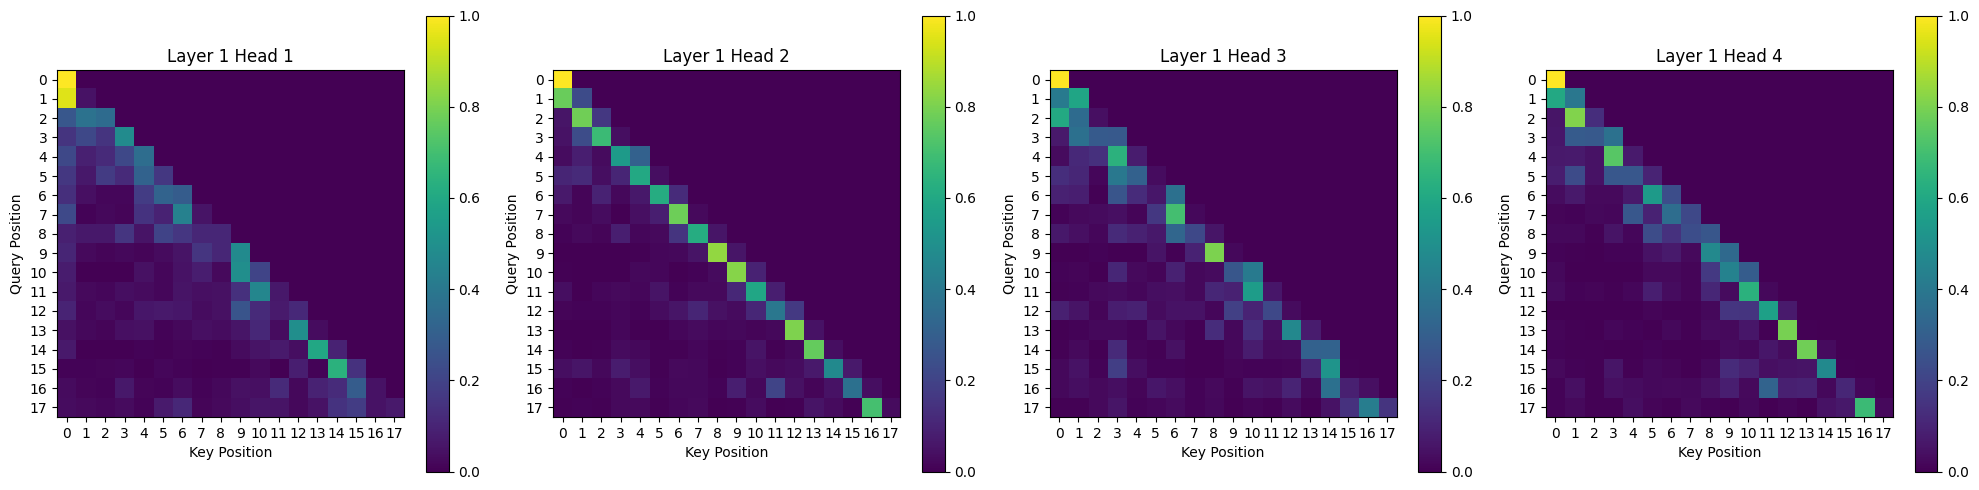

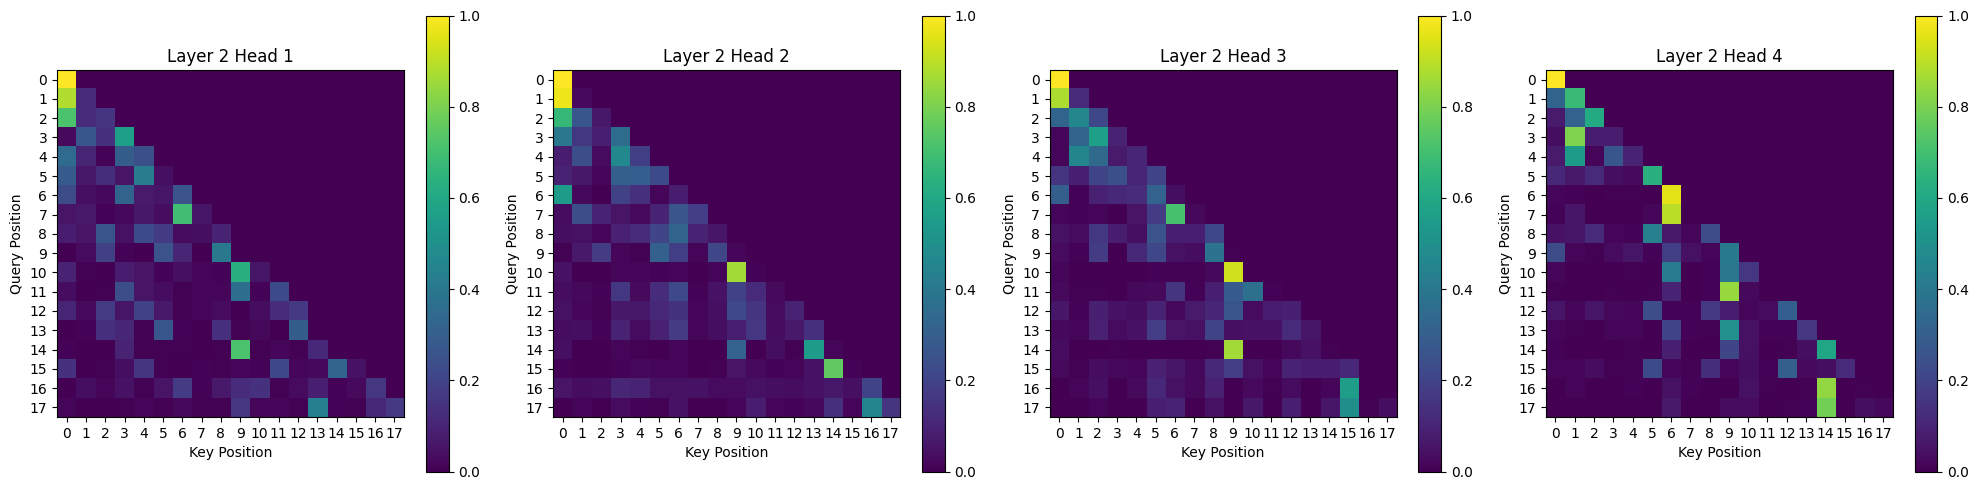

Tiny GPT - MoE Attentions


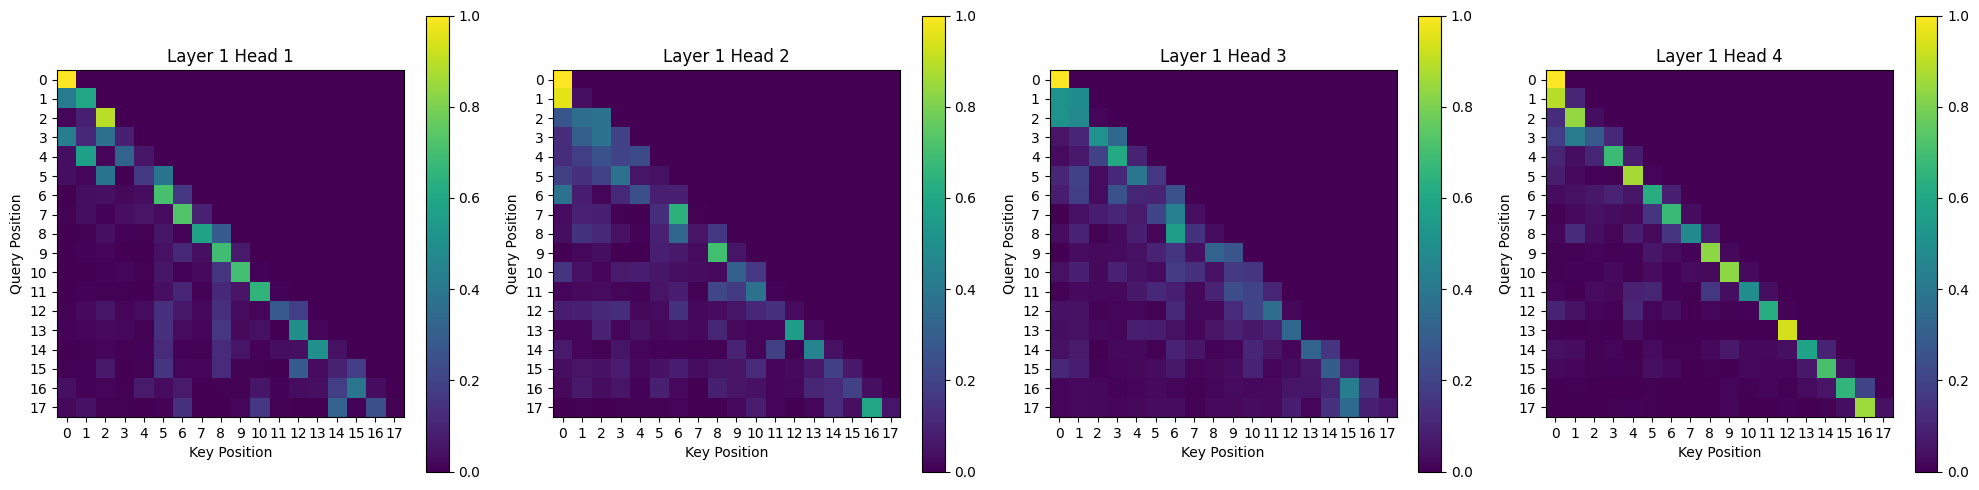

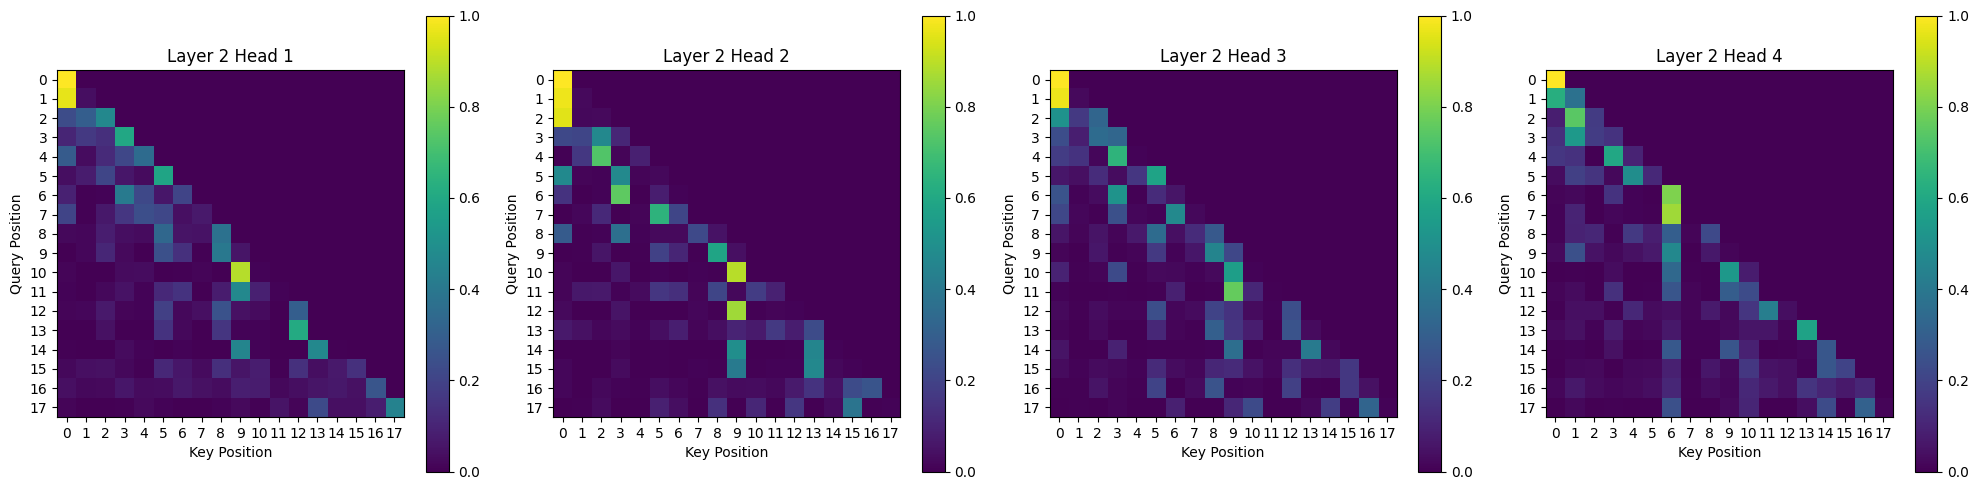

In [58]:
prompt = "To be or not to be"
print("Tiny GPT Attentions")
visualize_attention(model, prompt)
print("Tiny GPT - MoE Attentions")
visualize_attention(model_moe, prompt)

# Conclusiones

Se logro implementar con exito una funcion de generacion de texto con diferentes metodos de muestreo y decodificacion. A diferencia de la decodificacion greedy, los metodos de muestreo con temperature y top-k/top-p permiten generar secuencia de texto mas variadas ya que se introduce aleatoriedad en la seleccion de tokens.

Se implemento una arquitectura Mixture of Experts (MoE) en TinyGPT, permitiendo que diferentes tokens sean procesados por diferentes modelos feedforward especializados. Esto aumenta la capacidad del modelo sin incrementar significativamente el costo computacional, ya que cada token solo es procesado por un subconjunto de expertos. 

Se entreno una version base de TinyGPT y una version MoE respetando los conjuntos de datos y cantidad de epocas (100). Los resultados tanto para la version base como para la version MoE fueron similares en terminos de calidad ya que ninguno de los dos modelos logro un buen desempeño en la generacion de texto. Porbablemente el cuello d ebotella fue el encoder ya que se utilizo un encoder simple basado en caracteres. Por otro lado, la cantidad de epochs puede no haber sido suficiente para que el modelo converja a un minimo de la funcion de perdida. Debido a limitaciones de tiempo se decidio mantener las epocas en 100.


# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

